In [1]:
import numpy as np # linear algebra
import pandas as pd
pd.set_option("display.max_rows", 101)
import os


import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15

import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import cv2
from tqdm import tqdm
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
print(os.listdir('input/'))

['sample_submission.csv', 'test_images', 'train.csv', 'train_images']


In [3]:
train_df = pd.read_csv(r"input/train.csv")
sample_df = pd.read_csv(r"input/sample_submission.csv")

In [4]:
train_df.head()


ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  00031f466.jpg_1                                                NaN

In [5]:
sample_df.head()

ImageId_ClassId EncodedPixels
0  004f40c73.jpg_1           1 1
1  004f40c73.jpg_2           1 1
2  004f40c73.jpg_3           1 1
3  004f40c73.jpg_4           1 1
4  006f39c41.jpg_1           1 1

In [6]:
#Check number of each class
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

In [7]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 5902
the number of images with defects: 6666


defaultdict(int, {1: 897, 3: 5150, 4: 801, 2: 247})

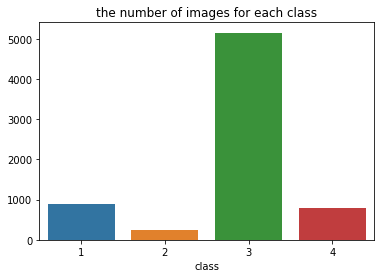

In [8]:
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict

In [9]:
class_dict


defaultdict(int, {1: 897, 3: 5150, 4: 801, 2: 247})

defaultdict(int, {1: 6239, 0: 5902, 2: 425, 3: 2})

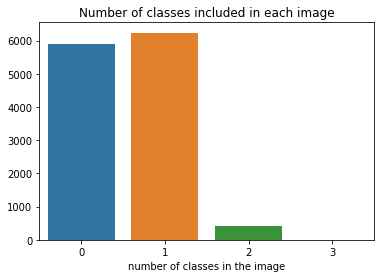

In [10]:
# Each image can have multiple defect classes
# check how many images have different classes
fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image");
ax.set_xlabel("number of classes in the image")
kind_class_dict

# Rough descriiption of defect types


１、Multiple chips on the surface
２、Single Vertical crack
３、Multiple vertical cracks
４、Muliptle large surface patches

In [11]:
train_size_dict = defaultdict(int)
train_path = Path(r"input/train_images/")

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1

In [12]:
train_size_dict


defaultdict(int, {(1600, 256): 12568})

In [13]:
test_size_dict = defaultdict(int)
test_path = Path("/input/test_images/")

for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_size_dict[img.size] += 1

In [14]:
test_size_dict

defaultdict(int, {(1600, 256): 12568})

### All images have the same shape

In [15]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

In [16]:
def name_and_mask(start_idx):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = train_df.iloc[col:col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask

In [17]:
def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

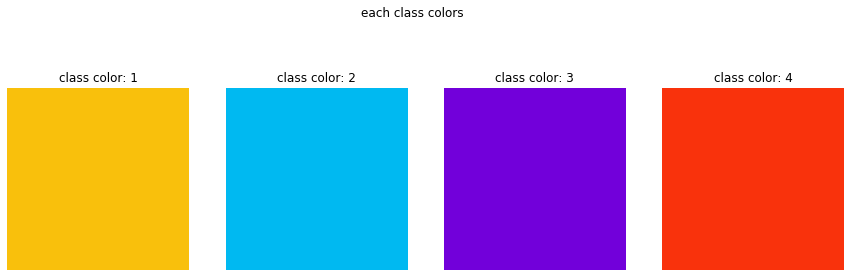

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

# Visualize the images

In [19]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_multi.append(col)

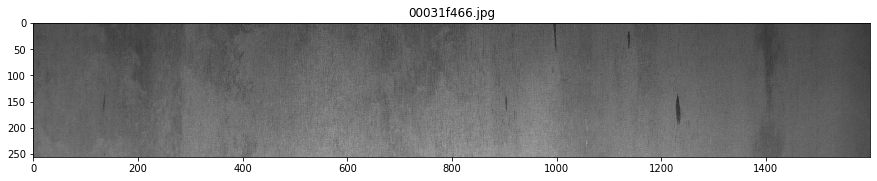

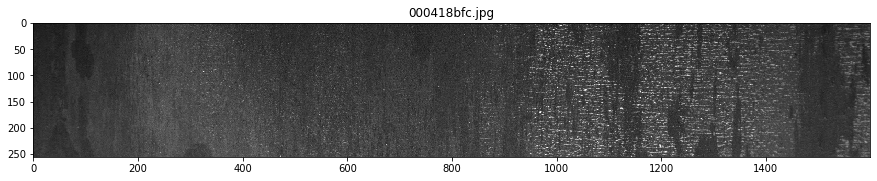

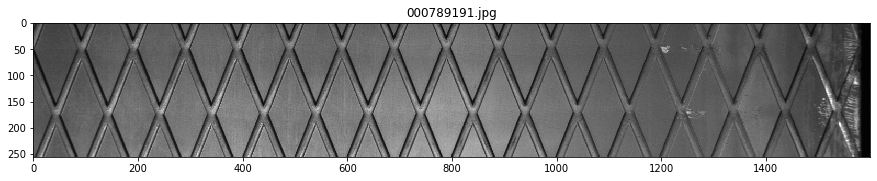

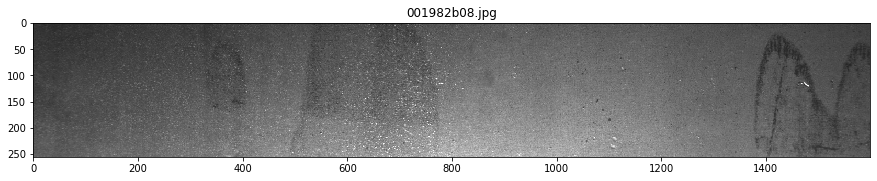

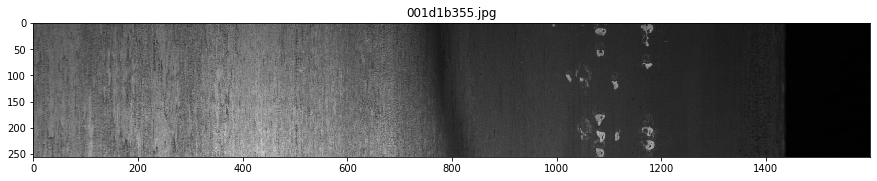

In [20]:
for idx in idx_no_defect[:5]:
    show_mask_image(idx)

In [21]:
del idx

# Images with defect label ==1

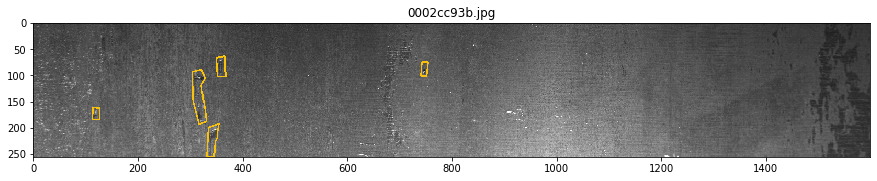

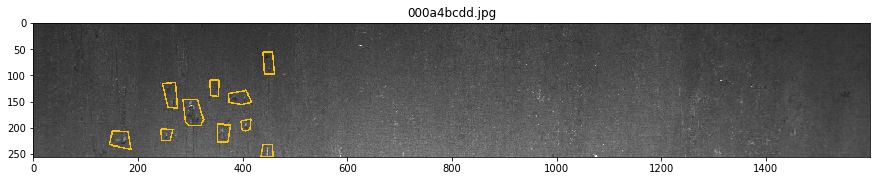

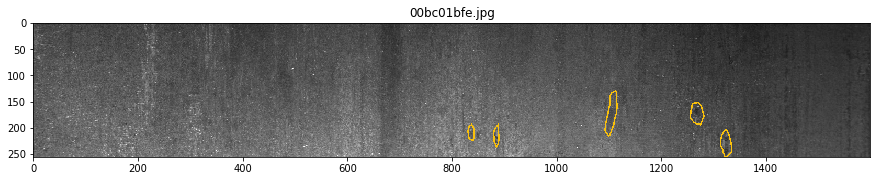

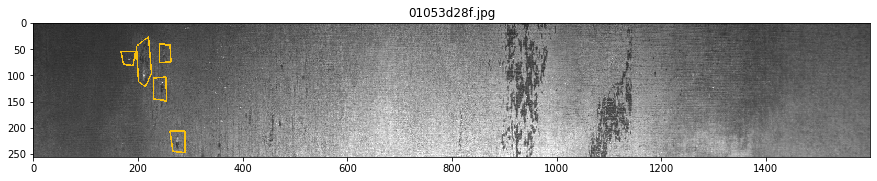

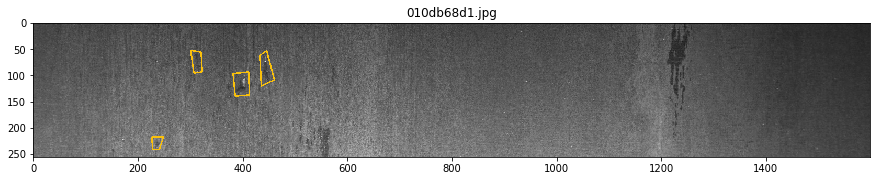

In [22]:
for idx in idx_class_1[:5]:
    show_mask_image(idx)

# Images with defects label ==2

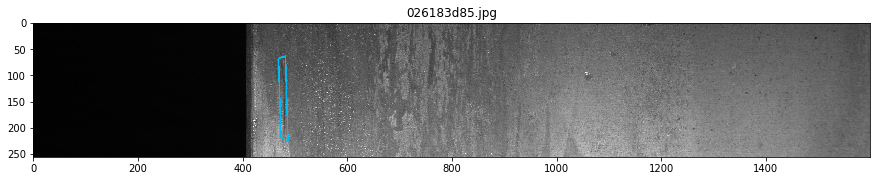

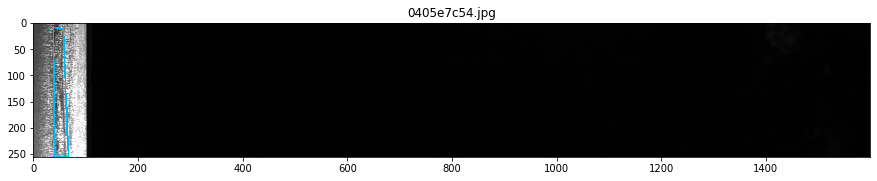

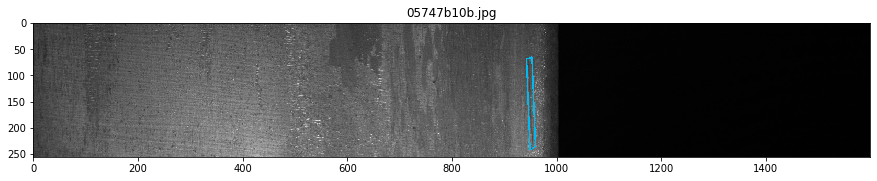

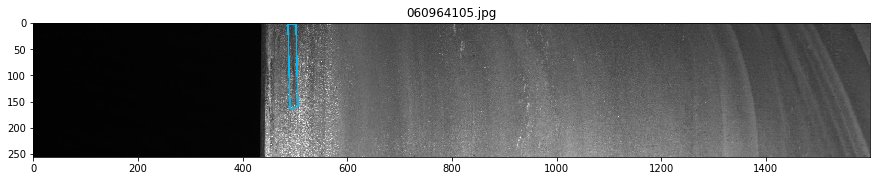

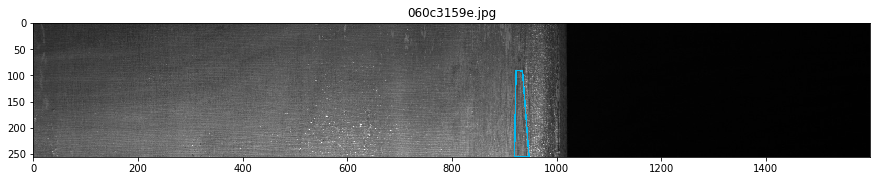

In [23]:
for idx in idx_class_2[:5]:
    show_mask_image(idx)

# Images with defect label == 3

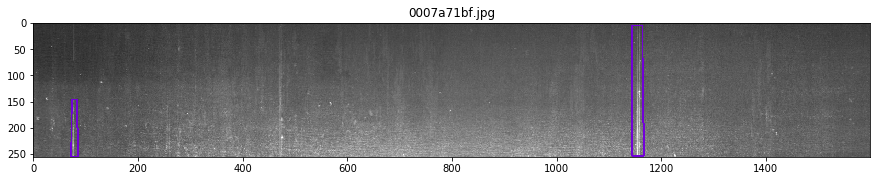

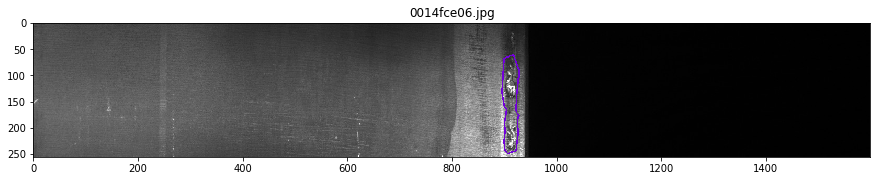

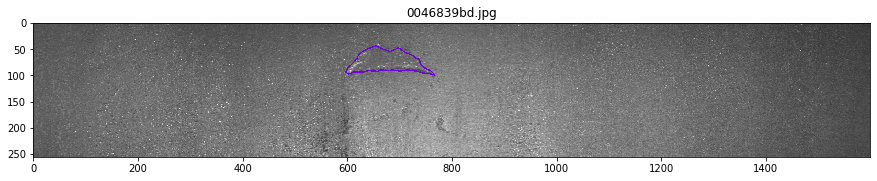

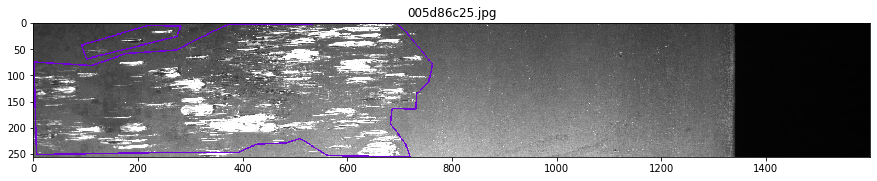

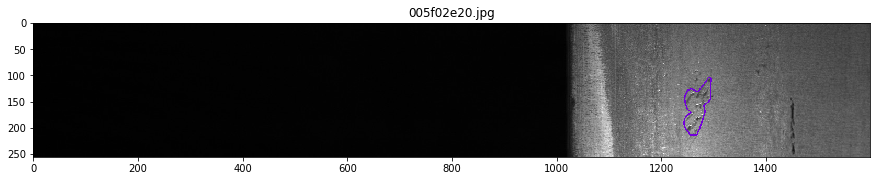

In [24]:
for idx in idx_class_3[:5]:
    show_mask_image(idx)

# IMages with defect label == 4

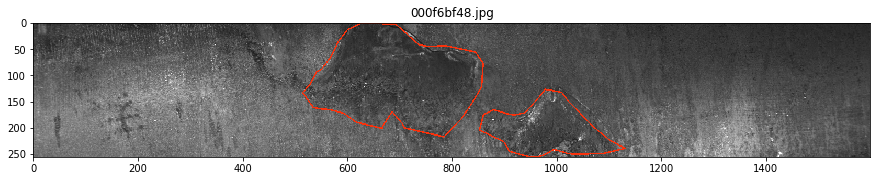

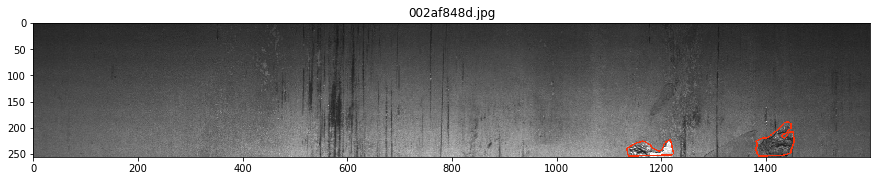

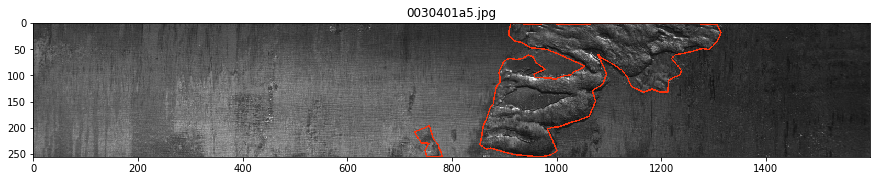

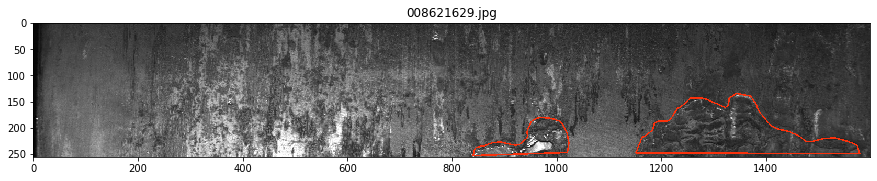

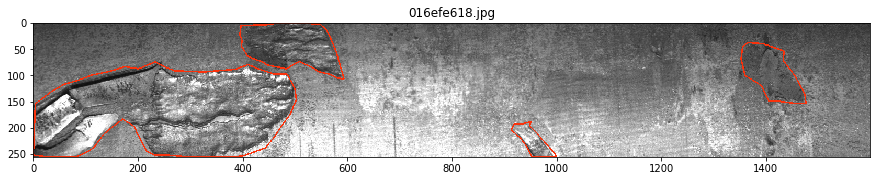

In [25]:
for idx in idx_class_4[:5]:
    show_mask_image(idx)

# Images with defect Multilabel

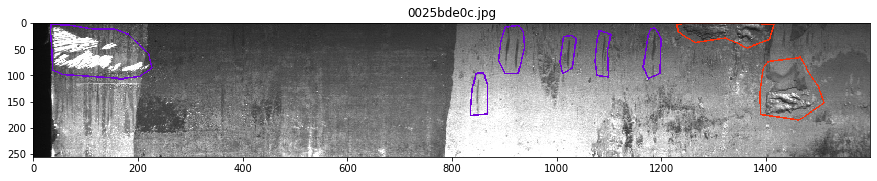

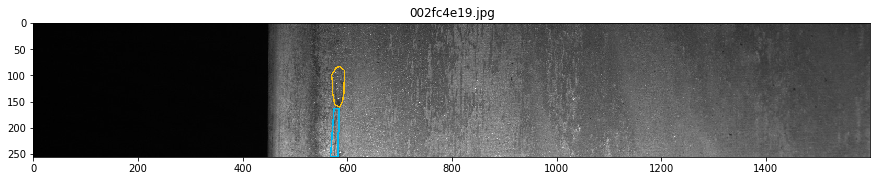

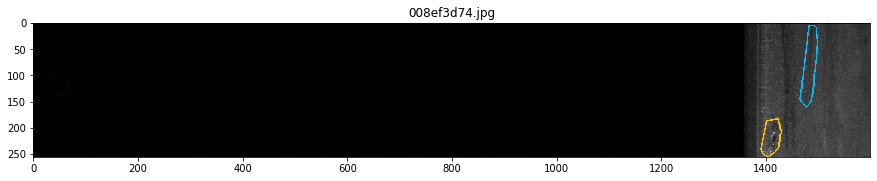

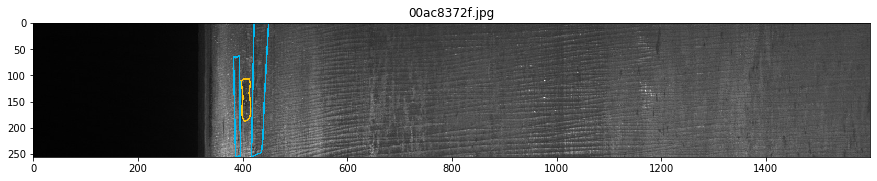

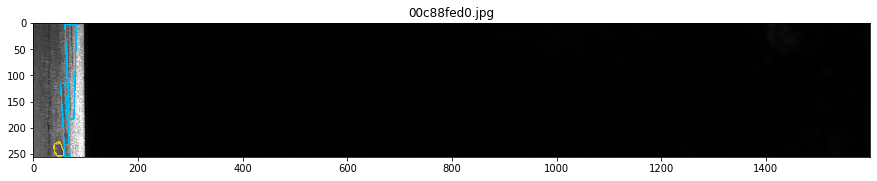

In [26]:
for idx in idx_class_multi[:5]:
    show_mask_image(idx)

# Images with defect contact 3 label types

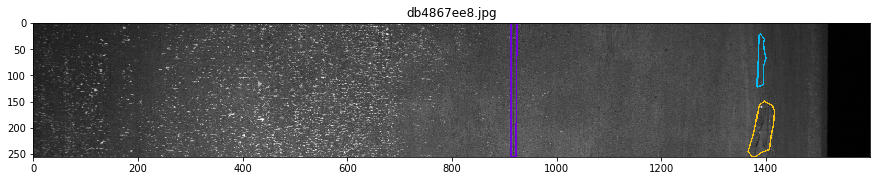

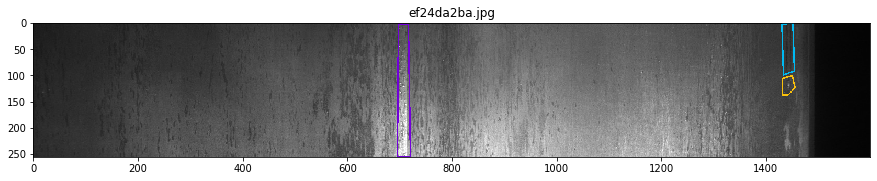

In [27]:
for idx in idx_class_triple:
    show_mask_image(idx)

# Prepare the data

In [28]:
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])


In [29]:
train_df['hasMask']=~train_df['EncodedPixels'].isna()

In [30]:
train_df.head()

ImageId_ClassId                                      EncodedPixels  \
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
1  0002cc93b.jpg_2                                                NaN   
2  0002cc93b.jpg_3                                                NaN   
3  0002cc93b.jpg_4                                                NaN   
4  00031f466.jpg_1                                                NaN   

         ImageId ClassId  hasMask  
0  0002cc93b.jpg       1     True  
1  0002cc93b.jpg       2    False  
2  0002cc93b.jpg       3    False  
3  0002cc93b.jpg       4    False  
4  00031f466.jpg       1    False

In [31]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


ImageId  hasMask
10803  db4867ee8.jpg      3.0
11776  ef24da2ba.jpg      3.0
6284   7f30b9c64.jpg      2.0
9421   bf0c81db6.jpg      2.0
9615   c314f43f3.jpg      2.0

In [32]:
print('Dataframe Shape: ', train_df.shape)

Dataframe Shape:  (50272, 5)


In [57]:
sample_df['ImageId'] = sample_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
sample_df['ClassId'] = sample_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])

test_imgs = pd.DataFrame(sample_df['ImageId'].unique(), columns=['ImageId'])

In [58]:
test_imgs.head()

ImageId
0  004f40c73.jpg
1  006f39c41.jpg
2  00b7fb703.jpg
3  00bbcd9af.jpg
4  0108ce457.jpg

# UTILITY FUNCTIONS

## Encoding & Decoding Mask

##### Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [63]:
sub_df = pd.read_csv('input/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [35]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [36]:
def rle2mask(mask_rle, shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [37]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

In [38]:
def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

## Loss Function

##### Source for bce_dice_loss: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [39]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [40]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [41]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Sample Test

In [42]:
sample_filename = 'db4867ee8.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]

In [43]:
sample_image_df

ImageId_ClassId                                      EncodedPixels  \
43212  db4867ee8.jpg_1  349941 2 350194 6 350447 11 350700 15 350953 1...   
43213  db4867ee8.jpg_2  354411 17 354634 50 354857 82 355096 99 355351...   
43214  db4867ee8.jpg_3                              233729 3008 236801 64   
43215  db4867ee8.jpg_4                                                NaN   

             ImageId ClassId  hasMask  
43212  db4867ee8.jpg       1     True  
43213  db4867ee8.jpg       2     True  
43214  db4867ee8.jpg       3     True  
43215  db4867ee8.jpg       4    False

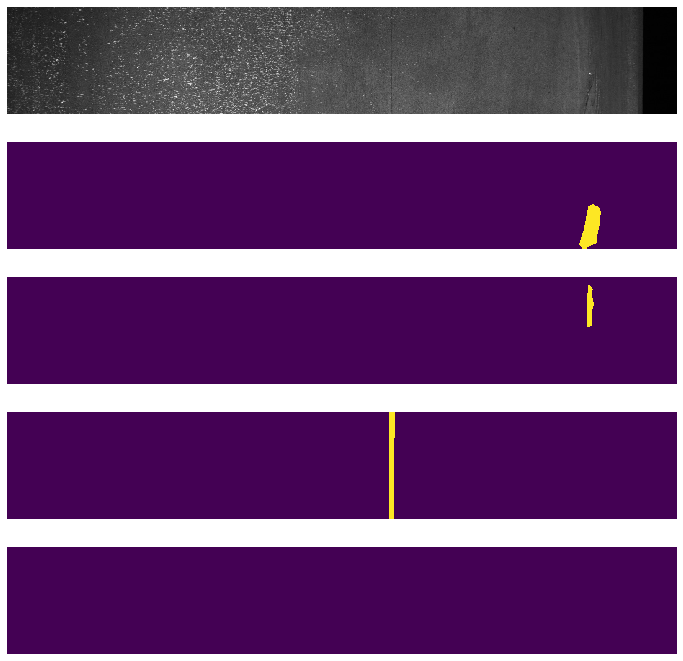

In [44]:
sample_path = f"input/train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

In [45]:
mask_count_df.head()

ImageId  hasMask
10803  db4867ee8.jpg      3.0
11776  ef24da2ba.jpg      3.0
6284   7f30b9c64.jpg      2.0
9421   bf0c81db6.jpg      2.0
9615   c314f43f3.jpg      2.0

# Data Generator

In [46]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='input/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [47]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [48]:
train_generator

# Build Model

In [49]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

#     c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
#     c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
#     p2 = MaxPooling2D((2, 2)) (c2)

#     c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
#     c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
#     p3 = MaxPooling2D((2, 2)) (c3)

#     c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
#     c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
#     p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

#     c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
#     c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
#     p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

#     c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
#     c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

#     u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
#     u6 = concatenate([u6, c5])
#     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
#     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

#     u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
#     u71 = concatenate([u71, c4])
#     c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
#     c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

#     u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
#     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

#     u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
#     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

#     u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
#     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c1) # to run all models change to c9

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

# Training

In [50]:
model = build_model((256, 1600, 1))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 1600, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 1600, 8)      80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 1600, 8)      584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 1600, 4)      36        
Total params: 700
Trainable params: 700
Non-trainable params: 0
_________________________________________________________________


In [52]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [53]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=3
)

Epoch 1/3


177/667 [======>.......................] - ETA: 29:16 - loss: 1.8036 - dice_coef: 0.00 - ETA: 27:05 - loss: 1.7894 - dice_coef: 0.01 - ETA: 26:07 - loss: 1.7789 - dice_coef: 0.01 - ETA: 25:24 - loss: 1.7698 - dice_coef: 0.01 - ETA: 25:03 - loss: 1.7602 - dice_coef: 0.01 - ETA: 24:48 - loss: 1.7503 - dice_coef: 0.01 - ETA: 24:27 - loss: 1.7400 - dice_coef: 0.01 - ETA: 24:11 - loss: 1.7306 - dice_coef: 0.01 - ETA: 23:56 - loss: 1.7200 - dice_coef: 0.01 - ETA: 23:48 - loss: 1.7106 - dice_coef: 0.01 - ETA: 23:48 - loss: 1.7014 - dice_coef: 0.01 - ETA: 24:03 - loss: 1.6931 - dice_coef: 0.01 - ETA: 24:18 - loss: 1.6840 - dice_coef: 0.01 - ETA: 24:28 - loss: 1.6735 - dice_coef: 0.01 - ETA: 24:37 - loss: 1.6646 - dice_coef: 0.01 - ETA: 24:44 - loss: 1.6560 - dice_coef: 0.01 - ETA: 24:49 - loss: 1.6476 - dice_coef: 0.01 - ETA: 24:54 - loss: 1.6377 - dice_coef: 0.01 - ETA: 25:05 - loss: 1.6294 - dice_coef: 0.01 - ETA: 25:13 - loss: 1.6207 - dice_coef: 0.01 - ETA: 25:23 - loss: 1.6120 - dice_coef

355/667 [==============>...............] - ETA: 22:50 - loss: 1.1799 - dice_coef: 0.01 - ETA: 22:48 - loss: 1.1791 - dice_coef: 0.01 - ETA: 22:45 - loss: 1.1784 - dice_coef: 0.01 - ETA: 22:43 - loss: 1.1777 - dice_coef: 0.01 - ETA: 22:41 - loss: 1.1770 - dice_coef: 0.01 - ETA: 22:38 - loss: 1.1764 - dice_coef: 0.01 - ETA: 22:36 - loss: 1.1758 - dice_coef: 0.01 - ETA: 22:33 - loss: 1.1753 - dice_coef: 0.01 - ETA: 22:31 - loss: 1.1747 - dice_coef: 0.01 - ETA: 22:28 - loss: 1.1740 - dice_coef: 0.01 - ETA: 22:26 - loss: 1.1735 - dice_coef: 0.01 - ETA: 22:23 - loss: 1.1728 - dice_coef: 0.01 - ETA: 22:21 - loss: 1.1722 - dice_coef: 0.01 - ETA: 22:19 - loss: 1.1715 - dice_coef: 0.01 - ETA: 22:16 - loss: 1.1708 - dice_coef: 0.01 - ETA: 22:14 - loss: 1.1703 - dice_coef: 0.01 - ETA: 22:12 - loss: 1.1696 - dice_coef: 0.01 - ETA: 22:09 - loss: 1.1690 - dice_coef: 0.01 - ETA: 22:07 - loss: 1.1683 - dice_coef: 0.01 - ETA: 22:05 - loss: 1.1678 - dice_coef: 0.01 - ETA: 22:02 - loss: 1.1671 - dice_coef

533/667 [======================>.......] - ETA: 16:36 - loss: 1.1089 - dice_coef: 0.01 - ETA: 16:33 - loss: 1.1087 - dice_coef: 0.01 - ETA: 16:30 - loss: 1.1085 - dice_coef: 0.01 - ETA: 16:27 - loss: 1.1082 - dice_coef: 0.01 - ETA: 16:24 - loss: 1.1080 - dice_coef: 0.01 - ETA: 16:21 - loss: 1.1078 - dice_coef: 0.01 - ETA: 16:18 - loss: 1.1076 - dice_coef: 0.01 - ETA: 16:15 - loss: 1.1074 - dice_coef: 0.01 - ETA: 16:12 - loss: 1.1071 - dice_coef: 0.01 - ETA: 16:10 - loss: 1.1069 - dice_coef: 0.01 - ETA: 16:07 - loss: 1.1067 - dice_coef: 0.01 - ETA: 16:04 - loss: 1.1065 - dice_coef: 0.01 - ETA: 16:02 - loss: 1.1063 - dice_coef: 0.01 - ETA: 15:59 - loss: 1.1061 - dice_coef: 0.01 - ETA: 15:56 - loss: 1.1059 - dice_coef: 0.01 - ETA: 15:53 - loss: 1.1057 - dice_coef: 0.01 - ETA: 15:50 - loss: 1.1054 - dice_coef: 0.01 - ETA: 15:47 - loss: 1.1053 - dice_coef: 0.01 - ETA: 15:44 - loss: 1.1050 - dice_coef: 0.01 - ETA: 15:41 - loss: 1.1048 - dice_coef: 0.01 - ETA: 15:38 - loss: 1.1046 - dice_coef

667/667 [==============================] - ETA: 7:17 - loss: 1.0813 - dice_coef: 0.020 - ETA: 7:13 - loss: 1.0812 - dice_coef: 0.020 - ETA: 7:10 - loss: 1.0810 - dice_coef: 0.020 - ETA: 7:07 - loss: 1.0809 - dice_coef: 0.020 - ETA: 7:03 - loss: 1.0808 - dice_coef: 0.020 - ETA: 7:00 - loss: 1.0807 - dice_coef: 0.020 - ETA: 6:57 - loss: 1.0806 - dice_coef: 0.020 - ETA: 6:54 - loss: 1.0805 - dice_coef: 0.020 - ETA: 6:50 - loss: 1.0805 - dice_coef: 0.020 - ETA: 6:47 - loss: 1.0804 - dice_coef: 0.020 - ETA: 6:44 - loss: 1.0802 - dice_coef: 0.020 - ETA: 6:41 - loss: 1.0801 - dice_coef: 0.020 - ETA: 6:37 - loss: 1.0800 - dice_coef: 0.020 - ETA: 6:34 - loss: 1.0799 - dice_coef: 0.020 - ETA: 6:31 - loss: 1.0798 - dice_coef: 0.020 - ETA: 6:28 - loss: 1.0797 - dice_coef: 0.020 - ETA: 6:24 - loss: 1.0796 - dice_coef: 0.020 - ETA: 6:21 - loss: 1.0795 - dice_coef: 0.020 - ETA: 6:18 - loss: 1.0794 - dice_coef: 0.020 - ETA: 6:14 - loss: 1.0793 - dice_coef: 0.020 - ETA: 6:11 - loss: 1.0791 - dice_coef:

178/667 [=======>......................] - ETA: 35:25 - loss: 1.0345 - dice_coef: 0.01 - ETA: 35:49 - loss: 1.0259 - dice_coef: 0.01 - ETA: 34:57 - loss: 1.0346 - dice_coef: 0.01 - ETA: 33:58 - loss: 1.0317 - dice_coef: 0.01 - ETA: 33:17 - loss: 1.0273 - dice_coef: 0.02 - ETA: 32:46 - loss: 1.0325 - dice_coef: 0.02 - ETA: 32:39 - loss: 1.0287 - dice_coef: 0.02 - ETA: 32:32 - loss: 1.0258 - dice_coef: 0.02 - ETA: 32:25 - loss: 1.0246 - dice_coef: 0.02 - ETA: 32:00 - loss: 1.0240 - dice_coef: 0.02 - ETA: 31:39 - loss: 1.0230 - dice_coef: 0.02 - ETA: 31:22 - loss: 1.0255 - dice_coef: 0.02 - ETA: 31:07 - loss: 1.0236 - dice_coef: 0.02 - ETA: 30:52 - loss: 1.0231 - dice_coef: 0.02 - ETA: 30:39 - loss: 1.0245 - dice_coef: 0.03 - ETA: 30:25 - loss: 1.0236 - dice_coef: 0.02 - ETA: 30:15 - loss: 1.0233 - dice_coef: 0.02 - ETA: 30:06 - loss: 1.0235 - dice_coef: 0.03 - ETA: 29:57 - loss: 1.0229 - dice_coef: 0.02 - ETA: 29:48 - loss: 1.0220 - dice_coef: 0.03 - ETA: 29:41 - loss: 1.0216 - dice_coef

356/667 [===============>..............] - ETA: 23:03 - loss: 1.0143 - dice_coef: 0.03 - ETA: 23:01 - loss: 1.0144 - dice_coef: 0.03 - ETA: 22:58 - loss: 1.0144 - dice_coef: 0.03 - ETA: 22:55 - loss: 1.0143 - dice_coef: 0.03 - ETA: 22:52 - loss: 1.0143 - dice_coef: 0.03 - ETA: 22:49 - loss: 1.0143 - dice_coef: 0.03 - ETA: 22:46 - loss: 1.0143 - dice_coef: 0.03 - ETA: 22:43 - loss: 1.0142 - dice_coef: 0.03 - ETA: 22:40 - loss: 1.0142 - dice_coef: 0.03 - ETA: 22:38 - loss: 1.0142 - dice_coef: 0.03 - ETA: 22:35 - loss: 1.0142 - dice_coef: 0.03 - ETA: 22:32 - loss: 1.0141 - dice_coef: 0.03 - ETA: 22:29 - loss: 1.0141 - dice_coef: 0.03 - ETA: 22:26 - loss: 1.0139 - dice_coef: 0.03 - ETA: 22:23 - loss: 1.0139 - dice_coef: 0.03 - ETA: 22:21 - loss: 1.0138 - dice_coef: 0.03 - ETA: 22:18 - loss: 1.0136 - dice_coef: 0.03 - ETA: 22:15 - loss: 1.0137 - dice_coef: 0.03 - ETA: 22:12 - loss: 1.0137 - dice_coef: 0.03 - ETA: 22:09 - loss: 1.0137 - dice_coef: 0.03 - ETA: 22:06 - loss: 1.0137 - dice_coef

534/667 [=======================>......] - ETA: 14:42 - loss: 1.0113 - dice_coef: 0.03 - ETA: 14:39 - loss: 1.0112 - dice_coef: 0.03 - ETA: 14:36 - loss: 1.0112 - dice_coef: 0.03 - ETA: 14:33 - loss: 1.0112 - dice_coef: 0.03 - ETA: 14:30 - loss: 1.0112 - dice_coef: 0.03 - ETA: 14:28 - loss: 1.0112 - dice_coef: 0.03 - ETA: 14:25 - loss: 1.0113 - dice_coef: 0.03 - ETA: 14:22 - loss: 1.0113 - dice_coef: 0.03 - ETA: 14:19 - loss: 1.0112 - dice_coef: 0.03 - ETA: 14:16 - loss: 1.0111 - dice_coef: 0.03 - ETA: 14:13 - loss: 1.0111 - dice_coef: 0.03 - ETA: 14:10 - loss: 1.0110 - dice_coef: 0.03 - ETA: 14:07 - loss: 1.0110 - dice_coef: 0.03 - ETA: 14:05 - loss: 1.0110 - dice_coef: 0.03 - ETA: 14:02 - loss: 1.0111 - dice_coef: 0.03 - ETA: 13:59 - loss: 1.0111 - dice_coef: 0.03 - ETA: 13:56 - loss: 1.0111 - dice_coef: 0.03 - ETA: 13:53 - loss: 1.0111 - dice_coef: 0.03 - ETA: 13:50 - loss: 1.0110 - dice_coef: 0.03 - ETA: 13:48 - loss: 1.0110 - dice_coef: 0.03 - ETA: 13:45 - loss: 1.0109 - dice_coef

667/667 [==============================] - ETA: 6:15 - loss: 1.0089 - dice_coef: 0.038 - ETA: 6:12 - loss: 1.0090 - dice_coef: 0.038 - ETA: 6:10 - loss: 1.0090 - dice_coef: 0.038 - ETA: 6:07 - loss: 1.0090 - dice_coef: 0.038 - ETA: 6:04 - loss: 1.0090 - dice_coef: 0.038 - ETA: 6:01 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:58 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:56 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:53 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:50 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:47 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:45 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:42 - loss: 1.0088 - dice_coef: 0.038 - ETA: 5:39 - loss: 1.0088 - dice_coef: 0.038 - ETA: 5:36 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:34 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:31 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:28 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:25 - loss: 1.0089 - dice_coef: 0.038 - ETA: 5:22 - loss: 1.0090 - dice_coef: 0.038 - ETA: 5:20 - loss: 1.0089 - dice_coef:

178/667 [=======>......................] - ETA: 56:56 - loss: 0.9626 - dice_coef: 0.09 - ETA: 57:29 - loss: 0.9727 - dice_coef: 0.07 - ETA: 56:31 - loss: 0.9823 - dice_coef: 0.06 - ETA: 56:59 - loss: 0.9915 - dice_coef: 0.06 - ETA: 55:43 - loss: 1.0007 - dice_coef: 0.05 - ETA: 55:03 - loss: 0.9995 - dice_coef: 0.05 - ETA: 55:21 - loss: 1.0001 - dice_coef: 0.06 - ETA: 56:18 - loss: 0.9997 - dice_coef: 0.06 - ETA: 57:27 - loss: 1.0023 - dice_coef: 0.05 - ETA: 57:04 - loss: 1.0017 - dice_coef: 0.05 - ETA: 56:39 - loss: 1.0023 - dice_coef: 0.05 - ETA: 56:16 - loss: 0.9958 - dice_coef: 0.06 - ETA: 55:52 - loss: 0.9930 - dice_coef: 0.06 - ETA: 55:32 - loss: 0.9935 - dice_coef: 0.06 - ETA: 55:12 - loss: 0.9944 - dice_coef: 0.06 - ETA: 54:45 - loss: 0.9941 - dice_coef: 0.06 - ETA: 54:22 - loss: 0.9939 - dice_coef: 0.05 - ETA: 54:05 - loss: 0.9946 - dice_coef: 0.05 - ETA: 53:47 - loss: 0.9952 - dice_coef: 0.05 - ETA: 53:28 - loss: 0.9943 - dice_coef: 0.05 - ETA: 53:10 - loss: 0.9962 - dice_coef

356/667 [===============>..............] - ETA: 39:33 - loss: 1.0006 - dice_coef: 0.04 - ETA: 39:28 - loss: 1.0008 - dice_coef: 0.04 - ETA: 39:23 - loss: 1.0008 - dice_coef: 0.04 - ETA: 39:18 - loss: 1.0009 - dice_coef: 0.04 - ETA: 39:13 - loss: 1.0008 - dice_coef: 0.04 - ETA: 39:07 - loss: 1.0009 - dice_coef: 0.04 - ETA: 39:00 - loss: 1.0008 - dice_coef: 0.04 - ETA: 38:54 - loss: 1.0008 - dice_coef: 0.04 - ETA: 38:48 - loss: 1.0009 - dice_coef: 0.04 - ETA: 38:42 - loss: 1.0009 - dice_coef: 0.04 - ETA: 38:36 - loss: 1.0005 - dice_coef: 0.04 - ETA: 38:31 - loss: 1.0003 - dice_coef: 0.04 - ETA: 38:25 - loss: 1.0004 - dice_coef: 0.04 - ETA: 38:19 - loss: 1.0003 - dice_coef: 0.04 - ETA: 38:13 - loss: 1.0005 - dice_coef: 0.04 - ETA: 38:07 - loss: 1.0006 - dice_coef: 0.04 - ETA: 38:00 - loss: 1.0005 - dice_coef: 0.04 - ETA: 37:54 - loss: 1.0004 - dice_coef: 0.04 - ETA: 37:48 - loss: 1.0006 - dice_coef: 0.04 - ETA: 37:41 - loss: 1.0006 - dice_coef: 0.04 - ETA: 37:35 - loss: 1.0008 - dice_coef

534/667 [=======================>......] - ETA: 23:22 - loss: 1.0015 - dice_coef: 0.04 - ETA: 23:17 - loss: 1.0015 - dice_coef: 0.04 - ETA: 23:13 - loss: 1.0015 - dice_coef: 0.04 - ETA: 23:08 - loss: 1.0016 - dice_coef: 0.04 - ETA: 23:03 - loss: 1.0016 - dice_coef: 0.04 - ETA: 22:58 - loss: 1.0016 - dice_coef: 0.04 - ETA: 22:53 - loss: 1.0016 - dice_coef: 0.04 - ETA: 22:49 - loss: 1.0016 - dice_coef: 0.04 - ETA: 22:44 - loss: 1.0015 - dice_coef: 0.04 - ETA: 22:39 - loss: 1.0016 - dice_coef: 0.04 - ETA: 22:34 - loss: 1.0015 - dice_coef: 0.04 - ETA: 22:29 - loss: 1.0015 - dice_coef: 0.04 - ETA: 22:24 - loss: 1.0016 - dice_coef: 0.04 - ETA: 22:20 - loss: 1.0015 - dice_coef: 0.04 - ETA: 22:15 - loss: 1.0015 - dice_coef: 0.04 - ETA: 22:10 - loss: 1.0014 - dice_coef: 0.04 - ETA: 22:05 - loss: 1.0013 - dice_coef: 0.04 - ETA: 22:00 - loss: 1.0012 - dice_coef: 0.04 - ETA: 21:56 - loss: 1.0011 - dice_coef: 0.04 - ETA: 21:51 - loss: 1.0012 - dice_coef: 0.04 - ETA: 21:46 - loss: 1.0012 - dice_coef

667/667 [==============================] - ETA: 9:42 - loss: 1.0009 - dice_coef: 0.048 - ETA: 9:38 - loss: 1.0009 - dice_coef: 0.048 - ETA: 9:34 - loss: 1.0009 - dice_coef: 0.048 - ETA: 9:30 - loss: 1.0009 - dice_coef: 0.048 - ETA: 9:25 - loss: 1.0008 - dice_coef: 0.048 - ETA: 9:21 - loss: 1.0009 - dice_coef: 0.048 - ETA: 9:17 - loss: 1.0008 - dice_coef: 0.048 - ETA: 9:13 - loss: 1.0008 - dice_coef: 0.048 - ETA: 9:09 - loss: 1.0008 - dice_coef: 0.048 - ETA: 9:05 - loss: 1.0008 - dice_coef: 0.048 - ETA: 9:01 - loss: 1.0008 - dice_coef: 0.048 - ETA: 8:57 - loss: 1.0008 - dice_coef: 0.048 - ETA: 8:53 - loss: 1.0008 - dice_coef: 0.048 - ETA: 8:49 - loss: 1.0006 - dice_coef: 0.048 - ETA: 8:44 - loss: 1.0006 - dice_coef: 0.048 - ETA: 8:40 - loss: 1.0006 - dice_coef: 0.048 - ETA: 8:36 - loss: 1.0006 - dice_coef: 0.048 - ETA: 8:31 - loss: 1.0005 - dice_coef: 0.048 - ETA: 8:27 - loss: 1.0005 - dice_coef: 0.048 - ETA: 8:23 - loss: 1.0006 - dice_coef: 0.048 - ETA: 8:19 - loss: 1.0005 - dice_coef:

# Evaluation & Submission

In [64]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

TypeError: Object of type float32 is not JSON serializable

In [66]:
model.load_weights('model.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        base_path='input/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

500/500 [==============================] - ETA: 21 - ETA: 20 - ETA: 22 - ETA: 23 - ETA: 23 - ETA: 24 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 26 - ETA: 27 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28

500it [00:12, 41.03it/s]


500/500 [==============================] - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28

500it [00:13, 36.32it/s]


500/500 [==============================] - ETA: 35 - ETA: 33 - ETA: 33 - ETA: 34 - ETA: 38 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32

500it [00:14, 35.69it/s]


301/301 [==============================] - ETA: 19 - ETA: 18 - ETA: 19 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16

301it [00:08, 37.03it/s]


In [67]:
test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('submission.csv', index=False)